In [1]:
import pandas as pd
import numpy as np

Convert the SAM file to a dummy GFF so we can use `bedtools intersect` to get repeat coverage:

In [ ]:
with open("/Volumes/scratch/pycnogonum/genome/metridium_cont/metridium_scaffolds.sam", "r") as f:
    with open("/Volumes/scratch/pycnogonum/genome/metridium_cont/metridium_scaffolds.gff", "w") as w:
        for line in f.readlines():
            tmp = line.split("\t")
            seqname = tmp[2]
            source = "Metridium"
            feature = "read"
            start = int(tmp[3])
            end = start + len(tmp[9])
            score = 0
            strand = "."
            frame = "."
            attribute = f"ID={tmp[0]}"
            w.write(f"{seqname}\t{source}\t{feature}\t{start}\t{end}\t{score}\t{strand}\t{frame}\t{attribute}\n")

in the `metridium_cont` directory, run:

```bash
bedtools intersect -F 0.9 -wao -bed -a metridium_scaffolds.gff -b ../draft/repeats/repeat_masker/draft.fasta.out.gff > metridium_scaffolds.repeats
```

Now read the bed file, which is like two concatenated GFFs:

In [2]:
overlaps = pd.read_csv("/Volumes/scratch/pycnogonum/genome/metridium_cont/metridium_scaffolds.repeats", sep="\t", header=None)

In [3]:
def repeated(x, offset, length):
    seq = np.zeros(length, dtype=bool)
    start = x[12] - offset
    end = x[13] - offset
    seq[start:end] = True
    return seq

def percentage_repeated(read1):
    start = read1.iloc[0][3]
    end = read1.iloc[0][4]
    read_len = end - start
    # print(start, end)
    masked = read1.apply(lambda x: repeated(x, start, read_len), axis=1).transform(np.array)
    absolute_repeated = np.sum(np.sum(masked, axis=0) > 0)
    return absolute_repeated / read_len

In [4]:
metridium_repeated = overlaps.groupby(8).apply(percentage_repeated, include_groups=False)

In [8]:
metridium_repeated = pd.DataFrame(metridium_repeated)
metridium_repeated.columns = ["perc_repeats"]

In [14]:
def read_length(x):
    start = x.iloc[0][3]
    end = x.iloc[0][4]
    read_len = end - start
    return read_len
metridium_repeated["length"] = overlaps.groupby(8).apply(read_length, include_groups=False)

In [26]:
(metridium_repeated["perc_repeats"] > 0.5).sum()

4593

<Axes: xlabel='length', ylabel='perc_repeats'>

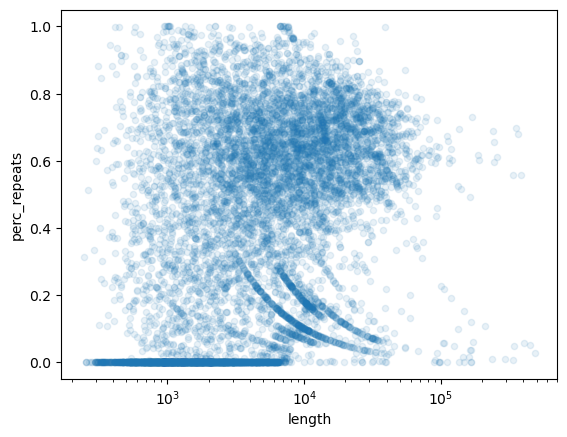

In [21]:
metridium_repeated.plot(x="length", y="perc_repeats", kind="scatter", alpha=0.1, logx=True)